In [1]:
import os
from pathlib import Path

current_path = Path(os.getcwd())
print(current_path) 

C:\Users\choir\바탕 화면\분석 멘멘\dogs vs cats


In [2]:
# 각자 데이터를 저장한 경로를 설정해주시면 됩니당
base_path = current_path
train_path = current_path / 'train'

print(train_path)

C:\Users\choir\바탕 화면\분석 멘멘\dogs vs cats\train


In [3]:
os.chdir(train_path)

### 데이터 shape 확인

In [4]:
import cv2
import numpy as np


for i in range(2):
    temp_path = os.listdir(train_path)[i]
    temp_path = str(temp_path)
    
    image = cv2.imread(temp_path)
    print(temp_path + " -> " + str(image.shape))

cat.0.jpg -> (374, 500, 3)
cat.1.jpg -> (280, 300, 3)


In [5]:
import pandas as pd

filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [6]:
df.tail()

,filename,category
24996,dog.9995.jpg,1
24997,dog.9996.jpg,1
24998,dog.9997.jpg,1
24999,dog.9998.jpg,1
25000,dog.9999.jpg,1


### 데이터 shape 맞추기 + Data Augmentation

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.30, random_state=42,shuffle=True) #재현성을 위해 여기 random_state는 고정!
train_df, validate_df = train_test_split(train_df, test_size=0.2,shuffle=True)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [8]:
# flow from dataframe 의 binary 사용하기 위해 변경
train_df["category"] = train_df["category"].replace({0: 'cat', 1: 'dog'}) 
validate_df["category"] = validate_df["category"].replace({0: 'cat', 1: 'dog'}) 

In [9]:
from keras.preprocessing.image import ImageDataGenerator

height, width = 120, 120
IMAGE_SIZE = (height,width)
batch_size = 128

In [10]:
import random

seed = 200823
random.seed(seed)

In [11]:
ImageDataGenerator(rescale=1./255, # 정규화
                    rotation_range=0, # 회전
                    shear_range=0., # 왜곡?
                    zoom_range=0., # 확대/축소
                    width_shift_range=0., # 좌우 이동
                    height_shift_range=0., # 상하 이동
                    channel_shift_range=0, # 채널 바꾸기
                    brightness_range=None, # 밝기 조절
                    fill_mode="nearest", # interpolation method -> "constant", "nearest", "reflect", "wrap"
                    horizontal_flip=False, # 상하 뒤집기
                    vertical_flip=False, # 좌우 뒤집기
                    validation_split=0.2,
                    data_format="channels_last") 
# channels_first: (batch_size, channels, height, width) / channel_last: (batch_size, height, width, channels)

### 각 파라미터가 뭘 뜻하는지, 어떤 값이 좋을지는 데이터를 만들어서 봅니다

In [12]:
TrainGenerator = ImageDataGenerator(rescale = 1./255)

train_generator = TrainGenerator.flow_from_dataframe(
    train_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 14000 validated image filenames belonging to 2 classes.


In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3499 validated image filenames belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


### sample 뽑아보기

In [14]:
import matplotlib.pyplot as plt


def plotImages(images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Found 14000 validated image filenames belonging to 2 classes.


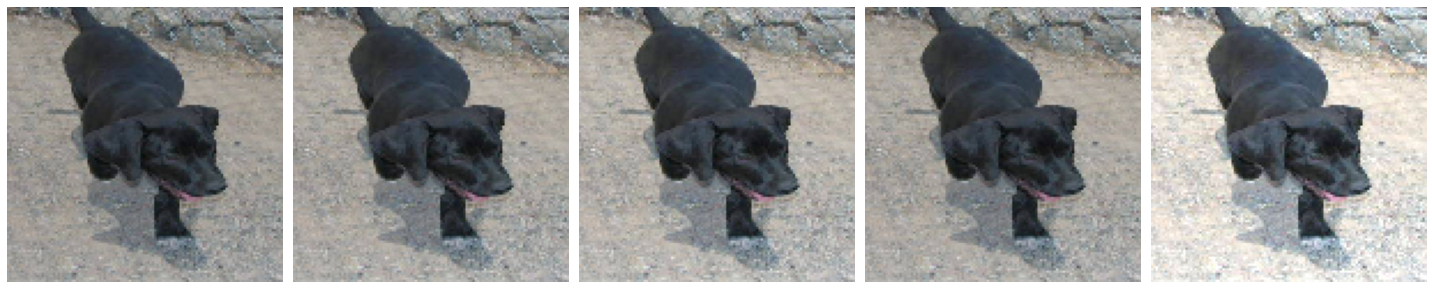

In [15]:
SampleGenerator = ImageDataGenerator(rescale=1./255, brightness_range=[0.8, 1.2])
samples = SampleGenerator.flow_from_dataframe(train_df,
                                              train_path,
                                              target_size=IMAGE_SIZE,
                                              batch_size=batch_size,
                                              x_col='filename',
                                              y_col='category',
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=seed)
sample = [samples[0][0][0] for i in range(5)]
plotImages(sample)

In [16]:
print(len(samples[0])) # 개 / 고양이
print(samples[0][0].shape) # batch_size
print(samples[0][0][0].shape) # 그 중 하나

2
(128, 120, 120, 3)
(120, 120, 3)


In [17]:
print(samples.class_indices)
print(samples.classes)

{'cat': 0, 'dog': 1}
[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 

In [18]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, LayerNormalization, Activation, ReLU, ELU, LeakyReLU, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, concatenate
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

Batch/Layer Normalization: https://a292run.tistory.com/entry/Different-Types-of-Normalization-in-Tensorflow-1

예시 (pretrained 모델 말고 직접 쌓아서 해봅시다)

##### 모델1

In [19]:
input = Input(shape=(height, width, 3))

model = Conv2D(filters=32, # Activation Map 개수
               kernel_size=(3, 3), # Activation Map 크기
               strides=(1, 1), # Stride 설정
               padding="same", # Conv 전후 크기가 같도록 Padding
               activation="relu" # Activation Function
               )(input)
model = MaxPooling2D(2, 2)(model)
model = Dropout(0.2)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(model)
model = MaxPooling2D(2, 2)(model)
model = Dropout(0.2)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(model)
model = MaxPooling2D(2, 2)(model)
model = Dropout(0.2)(model)

model = Flatten()(model)

output = Dense(2, activation="softmax")(model)

model = Model(inputs=input, outputs=output)

##### 모델3 

In [20]:
model3 = Sequential()

model3.add(Conv2D(input_shape=(height, width, 3), filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model3.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu"))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model3.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model3.add(MaxPooling2D(2, 2))
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(2, activation="softmax"))

##### 모델5

In [49]:
model5 = Sequential()

model5.add(Conv2D(input_shape=(height, width, 3), filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.2))

model5.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.2))

model5.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.2))

model5.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.2))

model5.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.2))

model5.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model5.add(MaxPooling2D(2, 2))
model5.add(Dropout(0.2))

model5.add(Flatten())

model5.add(Dense(2, activation="softmax"))

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)       

In [22]:
model3.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 120, 120, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 16)        0

In [50]:
model5.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 120, 120, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 30, 32)       

Keras에서

binary: 정답은 원 핫 인코딩 형태이고 출력은 class별 확률일 때

categorical: 정답은 원 핫 인코딩 형태이고 출력은 class별 확률일 때

sparse_categorical_crossentropy: 정답은 label 값 하나만 있고 출력은 class별 확률일 때

데이터 구성부터 모델 컴파일까지 주의하셔야 합니당

In [23]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam", # Adam(learning_rate=0.001)
              metrics=["accuracy"])

In [24]:
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) 

In [52]:
model5.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.009), metrics=['accuracy'])

ReduceLROnPlateau: Learning Rate를 Iteration, Epoch에 따라 줄여가는 스케줄러

EarlyStopping: 모델의 성능이 더 이상 좋아지지 않으면 학습을 끝냄 -> 과적합 방지에 이용

ModelCheckpoint: 성능이 가장 좋을 때 모델을 저장


In [25]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


early_stopper = EarlyStopping(monitor="val_loss",
                               mode="min",
                               verbose=0,
                               patience=10) # 10번 안에 좋아지지 못하면 멈춤

lr_scheduler = ReduceLROnPlateau(monitor="val_loss",
                                 factor=0.5, # Learning Rate를 줄여갈 배율
                                 patience=3, # 3번 안에 좋아지지 못하면 줄임
                                 verbose=1,
                                 min_delta=1e-4, # val_loss가 1e-4는 줄어야 좋아진걸로 보겠다!
                                 min_lr=1e-4) # 가능한 최소 Learning Rate

model_saver = ModelCheckpoint(train_path / "cats_n_dogs.h5",
                              monitor="val_accuracy",
                              mode="max",
                              verbose=0,
                              save_best_only=True)

In [26]:
train_iterations = train_generator.samples // batch_size
valid_iterations = validation_generator.samples // batch_size

print(train_iterations)
print(valid_iterations)

109
27


In [27]:
history = model.fit(train_generator,
                    steps_per_epoch=train_iterations,
                    validation_data=validation_generator,
                    validation_steps=valid_iterations,
                    epochs=10,
                    callbacks=[early_stopper, lr_scheduler, model_saver])

Epoch 1/10
109/109 [==============================] - 330s 3s/step - loss: 0.6706 - accuracy: 0.5690 - val_loss: 0.6154 - val_accuracy: 0.6658
Epoch 2/10
109/109 [==============================] - 287s 3s/step - loss: 0.5792 - accuracy: 0.6924 - val_loss: 0.5462 - val_accuracy: 0.7326
Epoch 3/10
109/109 [==============================] - 268s 2s/step - loss: 0.5399 - accuracy: 0.7284 - val_loss: 0.5501 - val_accuracy: 0.7083
Epoch 4/10
109/109 [==============================] - 264s 2s/step - loss: 0.4929 - accuracy: 0.7629 - val_loss: 0.4906 - val_accuracy: 0.7604
Epoch 5/10
109/109 [==============================] - 275s 3s/step - loss: 0.4714 - accuracy: 0.7784 - val_loss: 0.4760 - val_accuracy: 0.7737
Epoch 6/10
109/109 [==============================] - 280s 3s/step - loss: 0.4388 - accuracy: 0.7979 - val_loss: 0.4575 - val_accuracy: 0.7839
Epoch 7/10
109/109 [==============================] - 274s 3s/step - loss: 0.4216 - accuracy: 0.8104 - val_loss: 0.4242 - val_accuracy: 0.8134

In [28]:
history3 = model3.fit(train_generator,
                    steps_per_epoch=train_iterations,
                    validation_data=validation_generator,
                    validation_steps=valid_iterations,
                    epochs=10,
                    callbacks=[early_stopper, lr_scheduler, model_saver])

Epoch 1/10
109/109 [==============================] - 306s 3s/step - loss: 0.6822 - accuracy: 0.5435 - val_loss: 0.6883 - val_accuracy: 0.5307
Epoch 2/10
109/109 [==============================] - 287s 3s/step - loss: 0.6422 - accuracy: 0.6125 - val_loss: 0.6163 - val_accuracy: 0.6432
Epoch 3/10
109/109 [==============================] - 284s 3s/step - loss: 0.5960 - accuracy: 0.6696 - val_loss: 0.5795 - val_accuracy: 0.6950
Epoch 4/10
109/109 [==============================] - 287s 3s/step - loss: 0.5525 - accuracy: 0.7123 - val_loss: 0.5414 - val_accuracy: 0.7277
Epoch 5/10
109/109 [==============================] - 290s 3s/step - loss: 0.5185 - accuracy: 0.7375 - val_loss: 0.4980 - val_accuracy: 0.7575
Epoch 6/10
109/109 [==============================] - 284s 3s/step - loss: 0.4890 - accuracy: 0.7614 - val_loss: 0.4723 - val_accuracy: 0.7679
Epoch 7/10
109/109 [==============================] - 292s 3s/step - loss: 0.4473 - accuracy: 0.7838 - val_loss: 0.4249 - val_accuracy: 0.8058

In [29]:
history4 = model3.fit(train_generator,
                    steps_per_epoch=train_iterations,
                    validation_data=validation_generator,
                    validation_steps=valid_iterations,
                    epochs=15,
                    callbacks=[early_stopper, lr_scheduler, model_saver])

Epoch 1/15
109/109 [==============================] - 292s 3s/step - loss: 0.3407 - accuracy: 0.8471 - val_loss: 0.3434 - val_accuracy: 0.8403
Epoch 2/15
109/109 [==============================] - 293s 3s/step - loss: 0.3289 - accuracy: 0.8529 - val_loss: 0.3428 - val_accuracy: 0.8426
Epoch 3/15
109/109 [==============================] - 295s 3s/step - loss: 0.3123 - accuracy: 0.8638 - val_loss: 0.3212 - val_accuracy: 0.8553
Epoch 4/15
109/109 [==============================] - 292s 3s/step - loss: 0.3003 - accuracy: 0.8675 - val_loss: 0.3262 - val_accuracy: 0.8547
Epoch 5/15
109/109 [==============================] - 291s 3s/step - loss: 0.2863 - accuracy: 0.8744 - val_loss: 0.3117 - val_accuracy: 0.8689
Epoch 6/15
109/109 [==============================] - 288s 3s/step - loss: 0.2805 - accuracy: 0.8780 - val_loss: 0.2994 - val_accuracy: 0.8689
Epoch 7/15
109/109 [==============================] - 287s 3s/step - loss: 0.2626 - accuracy: 0.8842 - val_loss: 0.3463 - val_accuracy: 0.8490

In [53]:
history5 = model5.fit(train_generator,
                    steps_per_epoch=train_iterations,
                    validation_data=validation_generator,
                    validation_steps=valid_iterations,
                    epochs=15,
                    callbacks=[early_stopper, lr_scheduler, model_saver])

Epoch 1/15
109/109 [==============================] - 335s 3s/step - loss: 0.7099 - accuracy: 0.4958 - val_loss: 0.6933 - val_accuracy: 0.4928
Epoch 2/15
109/109 [==============================] - 280s 3s/step - loss: 0.6934 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5072
Epoch 3/15
109/109 [==============================] - 272s 2s/step - loss: 0.6936 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5064
Epoch 4/15
109/109 [==============================] - 310s 3s/step - loss: 0.6933 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5078
Epoch 5/15
109/109 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4999
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0044999998062849045.
109/109 [==============================] - 321s 3s/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6937 - val_accuracy: 0.4942
Epoch 6/15
109/109 [==============================] - 309s 3s/step - loss: 0.6933 - accuracy: 0.4960 - val_loss: 0.6933 

In [30]:
def plotHistory(history):
    fig, axes = plt.subplots(1, 2, figsize=(30, 10))
    axes = axes.flatten()
    for hist, ax in zip(["loss", "accuracy"], axes):
        ax.plot(history.history[hist], color="tab:green", label="train " + hist)
        ax.plot(history.history["val_" + hist], color="tab:pink", label="valid " + hist)
        # tab:blue, tab:orange, tab:green, tab:red, tab:purple, tab:brown, tab:pink, tab:gray, tab:olive, tab:cyan
        ax.legend()
    plt.show()

##### 모델1

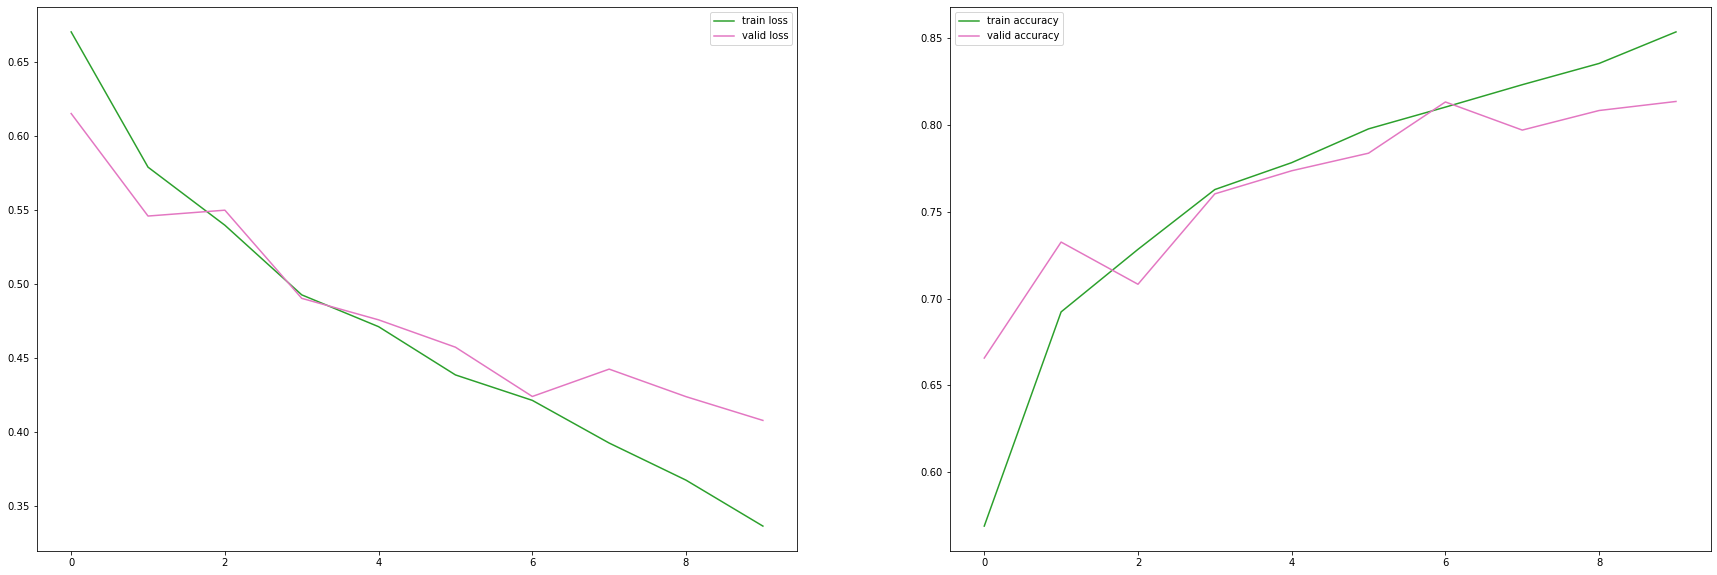

In [31]:
plotHistory(history)

##### 모델3

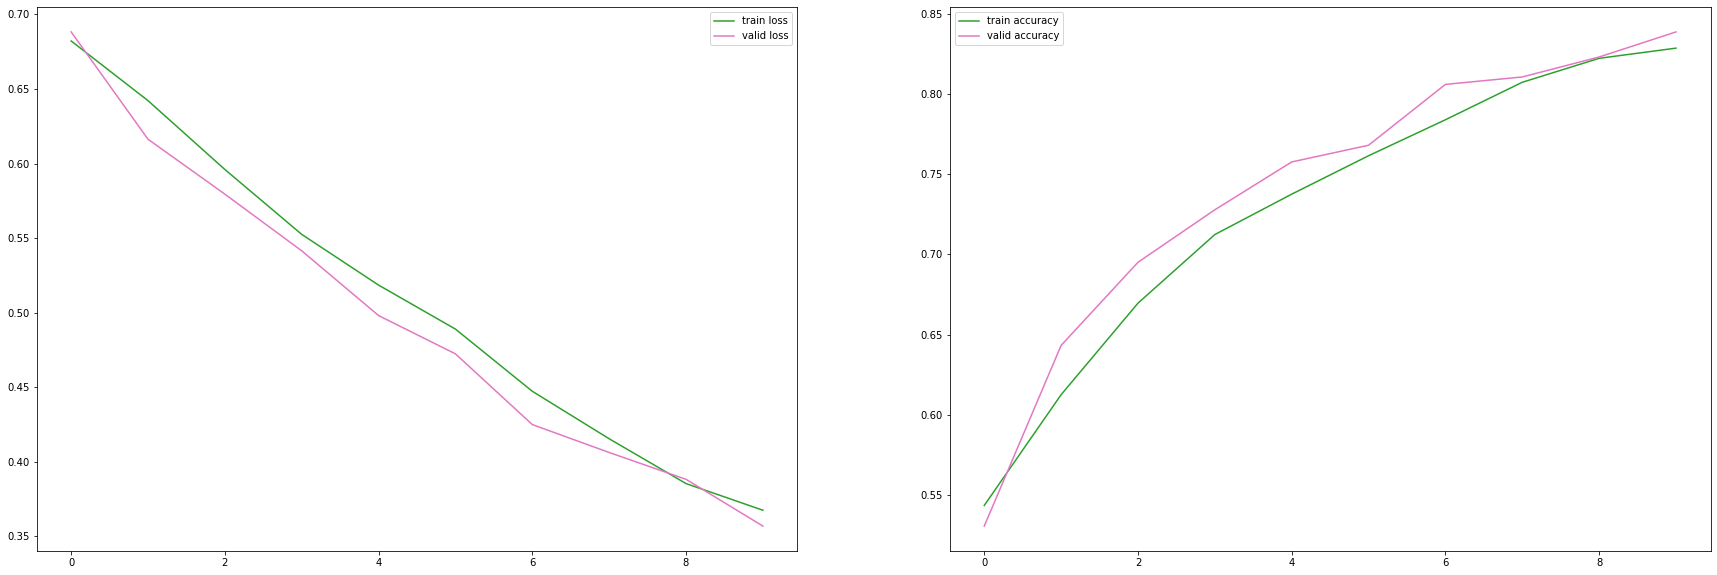

In [32]:
plotHistory(history3)

##### 모델3 - epoch 15

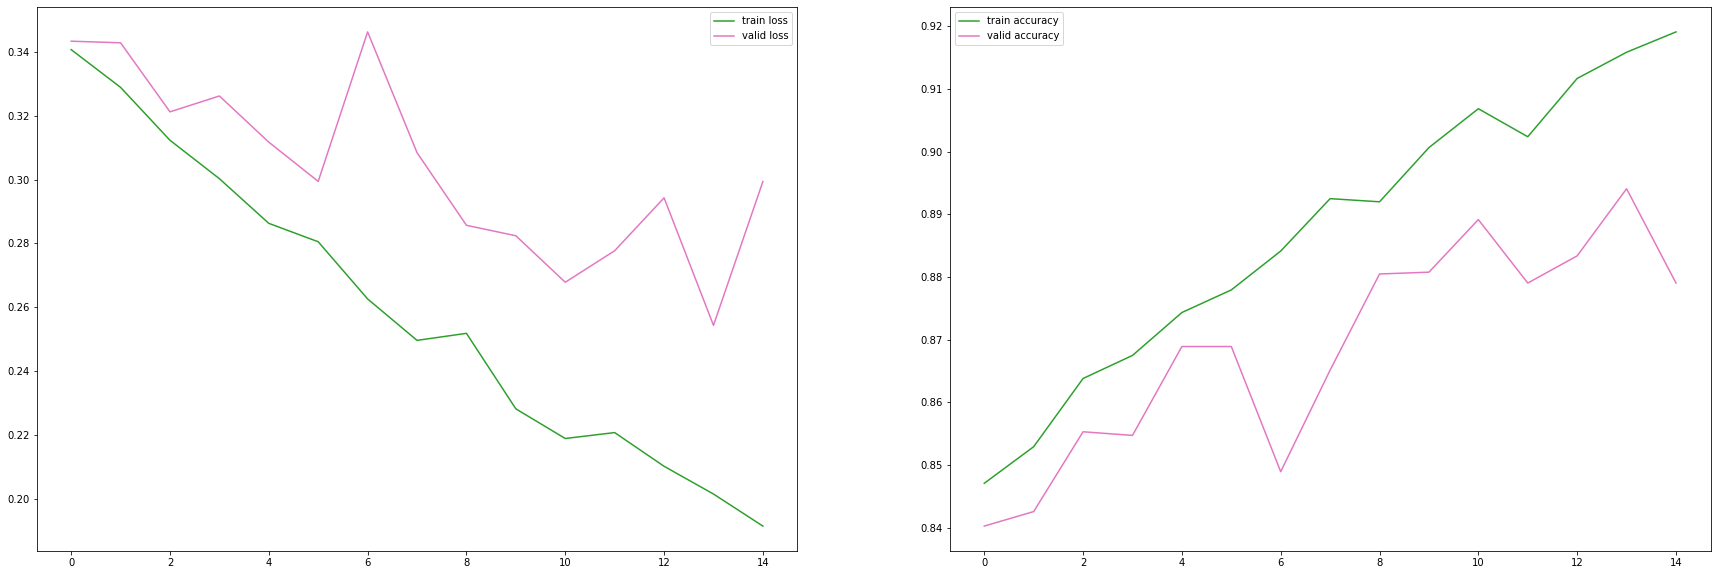

In [33]:
plotHistory(history4)

##### 모델5

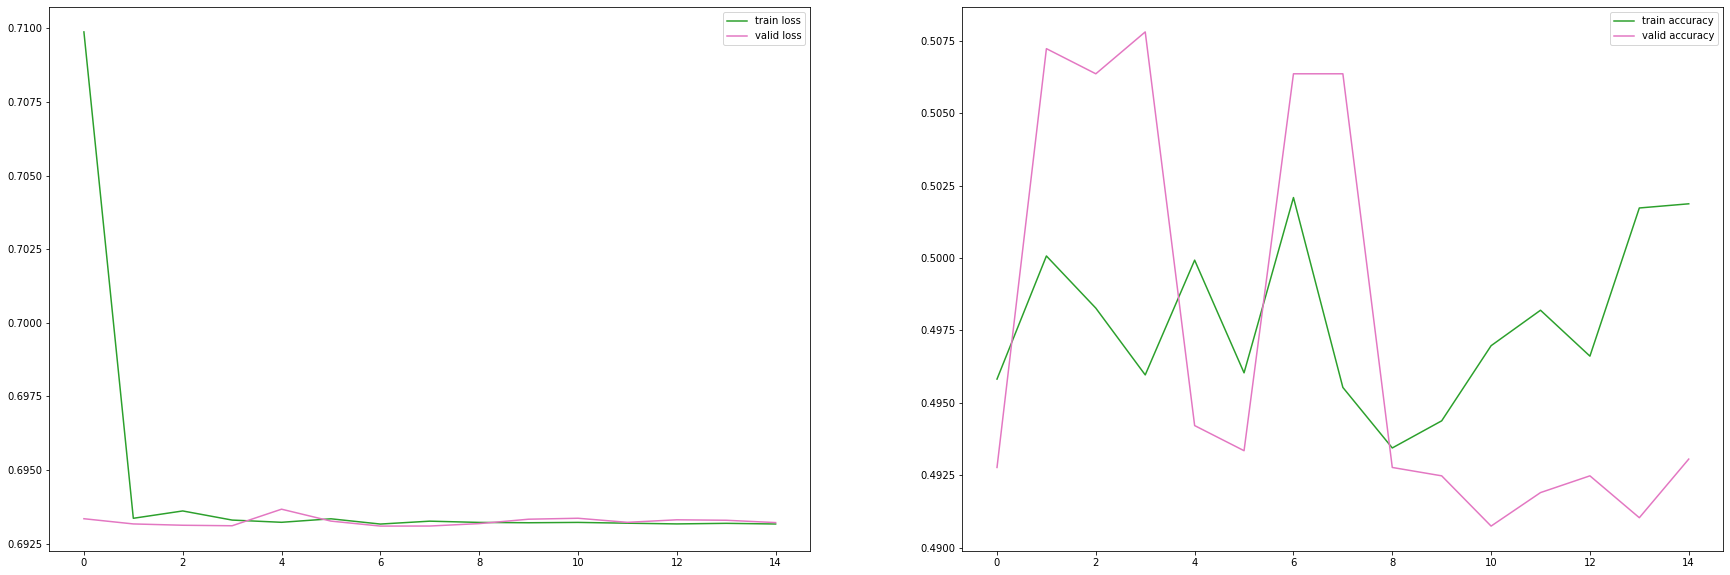

In [54]:
plotHistory(history5) #뭐노..

In [55]:
from keras.models import load_model

best_model = load_model(train_path / "cats_n_dogs.h5")

In [56]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    train_path, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 7501 validated image filenames.


In [57]:
predict = best_model.predict(test_generator, steps=np.ceil( test_df.shape[0]/batch_size))

In [58]:
pred_cat = np.argmax(predict, axis=-1)
real_cat = np.array(test_df['category'])

In [59]:
from sklearn.metrics import accuracy_score
score = accuracy_score(pred_cat,real_cat)

In [60]:
print(score)

0.9004132782295694
